In [31]:
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
import matplotlib.pyplot as plt
import torch


In [32]:
data_folder = '~/data/FMNIST'
data = torchvision.datasets.FashionMNIST(root=data_folder, train=True, download=True)

In [33]:
x = data.data
y = data.targets

In [34]:
class Data(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        self.x = x.view(-1, 28 * 28)
        self.y =y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x.to('cuda'), y.to('cuda')


In [35]:
dataset = Data(x, y)
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [36]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(28*28, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        ).to('cuda')

    def forward(self, x):
        return self.sequential(x)
    
    def return_opt_loss(self):
        opt = SGD(self.sequential.parameters(), lr=0.01)
        loss = nn.CrossEntropyLoss()
        return opt, loss
    
    def train(self):
        self.sequential.train()
        prediction = self.sequential(x)
        opt, loss = self.return_opt_loss()
        loss_func = loss(prediction, y)
        loss_func.backward()
        opt.step()
        opt.zero_grad()
        return loss_func.item()

    @torch.no_grad()
    def accuracy(self):
        self.sequential.eval()
        prediction = self.sequential(x)
        max_value, argmaxes = prediction.max(-1)
        is_correct = argmaxes == y
        return is_correct.cpu().numpy().tolist()


In [37]:
model = NeuralNet()
optimizer, loss = model.return_opt_loss()

In [38]:
trn_dl = dataloader
optimizer, loss_fn = model.return_opt_loss()
# train_batch = model.train()
# accuracy = model.accuracy()


In [39]:
import numpy as np
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = model.train()
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = model.accuracy()
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


/tmp/ipykernel_30769/1668084199.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


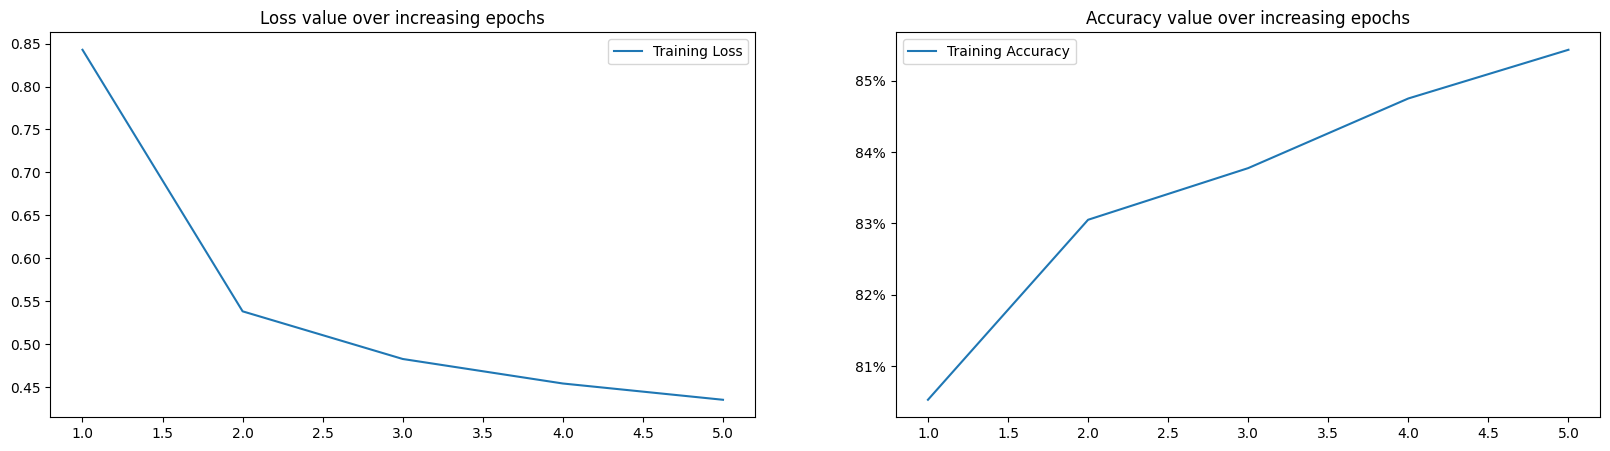

In [40]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

In [41]:
'acc is: ' + str((torch.tensor(accuracies).max()).item() * 100) + ' %'

'acc is: 85.43166666666666 %'